# TP Large Scale Kernel Methods

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [3]:
from sklearn.svm import SVC, LinearSVC
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()

clf = SVC(kernel =  'rbf')
clf.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()

accuracy_kernel = clf.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)


print('-----------------')
print("Fitting SVC linear on %d samples..." % X_train.shape[0])
t0 = time()

clf_linear = LinearSVC(dual=False)
clf_linear.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % X_test.shape[0])
t1 = time()

accuracy_kernel = clf_linear.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)


Fitting SVC rbf on 20000 samples...
done in 4.890s
Predicting with SVC rbf on 40000 samples...
done in 4.352s
classification accuracy: 0.980
-----------------
Fitting SVC linear on 20000 samples...
done in 0.114s
Predicting with SVC linear on 40000 samples...
done in 0.006s
classification accuracy: 0.917


## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [4]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, s, v = svds(gram_mat, k=k)
        s = np.diag(s)
        gram_mat_k = np.dot(np.dot(u,s),v)
        pass  # TODO
    else:
        u, s, v = svd(gram_mat)
        u = u[:,:k]
        v = v[:k,:]
        s = np.diag(s[:k])
        gram_mat_k = np.dot(np.dot(u,s),v)
        pass  # TODO
        
    
    return gram_mat_k


On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [5]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    
    rel_error[k] = np.linalg.norm(gram_signal-gram_mat_k)/np.linalg.norm(gram_signal)

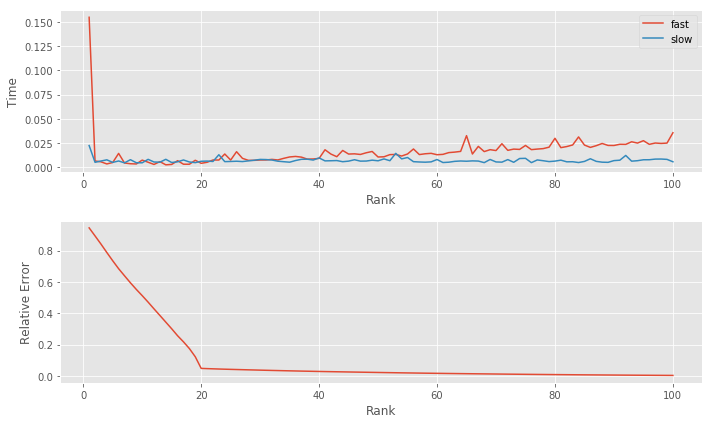

In [7]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [11]:
import math
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    W = np.random.randn(n_features,c)*2*gamma
    b = np.random.rand(1,c)*2*math.pi
       
    X_new_train = (np.sqrt(2/c)*np.cos(np.dot(X_train,W)+b))
    X_new_test = (np.sqrt(2/c)*np.cos(np.dot(X_test,W)+b))   
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [12]:
X_new_train, X_new_test = random_features(X_train, X_test, gamma=1/X_train.shape[1], c=300, seed=44)

t0 = time()
clf = LinearSVC(dual=False)
clf.fit(X_new_train,y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with Linear SVC 300 KF on %d samples..." % X_test.shape[0])
t1 = time()

accuracy_kernel = clf.score(X_new_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)

done in 1.067s
Predicting with Linear SVC 300 KF on 40000 samples...
done in 0.013s
classification accuracy: 0.938


## Question 6

On implémente la méthode de Nystrom.

In [13]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=300, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    u, s, v = svds(W, k)
    s = np.diag(1/np.sqrt(s))
    M = np.dot(u,s)
    
    C_test = rbf_kernel(X_test,X_train_idx, gamma=1/X_train.shape[1])
    C_train = rbf_kernel(X_train,X_train_idx, gamma=1/X_train.shape[1])
    
    X_new_train = np.dot(C_train,M)
    X_new_test = np.dot(C_test,M)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [14]:
gamma = 1/X_train.shape[1]
n_samples = X_train.shape[0]
n_samples_test = X_test.shape[0]

Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.132s
Predicting with SVC linear on 40000 samples...
done in 0.018s
classification accuracy: 0.976


## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [25]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_linear = np.zeros(n_ranks)
timing_rbf = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_linear = np.zeros(n_ranks)
accuracy_rbf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

t0 = time()
clf = SVC(kernel =  'rbf')
clf.fit(X_train,y_train)
accuracy_rbf = np.repeat(clf.score(X_test, y_test),n_ranks)
timing_rbf = np.repeat((time() - t0),n_ranks)

t0 = time()
clf = LinearSVC(dual=False)
clf.fit(X_train, y_train)
accuracy_linear = np.repeat(clf.score(X_test, y_test),n_ranks)
timing_linear = np.repeat((time() - t0),n_ranks)
    
for i, c in enumerate(ranks):
    print(i, c)
    t0 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=int(c/2), seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    timing_nystrom[i] = (time() - t0)
    
    
    t0 = time()
    X_new_train, X_new_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(X_new_train,y_train)
    accuracy_rkf[i] = clf.score(X_new_test,y_test)
    timing_rkf[i] = (time() - t0)
  


Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


In [ ]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_rbf * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_rbf * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()